### Финальный проект
Датасет содержит данные о погоде, собранные в городе Дели за период 4 лет (с 2013 по 2017 год).

In [2]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from numpy import asarray
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import warnings
import random
from pmdarima import auto_arima
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
from itertools import combinations
from statsmodels.tsa.stattools import coint, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from tensorflow import keras
from keras import Input, Model
from tcn import TCN


random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True

In [1]:
!pip install pmdarima
!pip install keras-tcn

  Using cached keras_tcn-3.5.0-py3-none-any.whl (13 kB)
  Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (611 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)


### Предобрабока временного ряда

In [163]:
data_train = pd.read_csv('DailyDelhiClimateTrain.csv')
data_test = pd.read_csv('DailyDelhiClimateTest.csv')

data = pd.concat([data_train, data_test], axis=0)
del data['meanpressure']
data.head()

,date,meantemp,humidity,wind_speed
0,2013-01-01,10.000000,84.500000,0.000000
1,2013-01-02,7.400000,92.000000,2.980000
2,2013-01-03,7.166667,87.000000,4.633333
3,2013-01-04,8.666667,71.333333,1.233333
4,2013-01-05,6.000000,86.833333,3.700000


In [164]:
data['date']=pd.to_datetime(data['date'])
data.set_index(data['date'], inplace=True)
data = data.drop('date', axis=1)

data.head()

,meantemp,humidity,wind_speed
date,,,
2013-01-01,10.000000,84.500000,0.000000
2013-01-02,7.400000,92.000000,2.980000
2013-01-03,7.166667,87.000000,4.633333
2013-01-04,8.666667,71.333333,1.233333
2013-01-05,6.000000,86.833333,3.700000


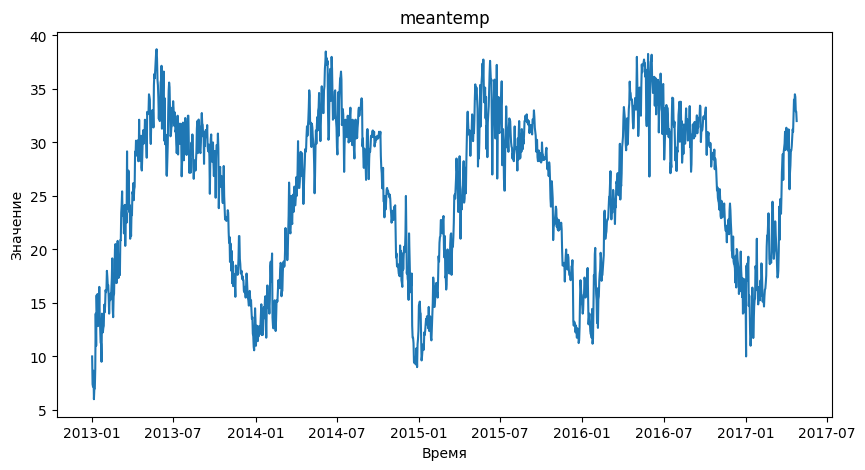

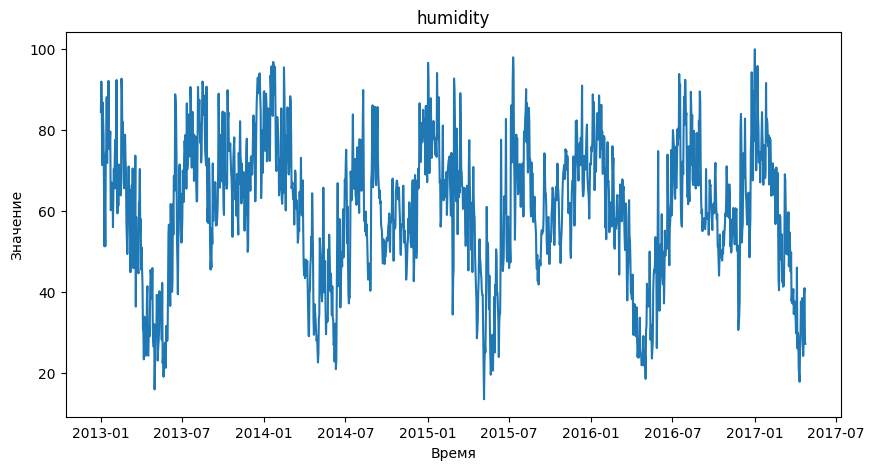

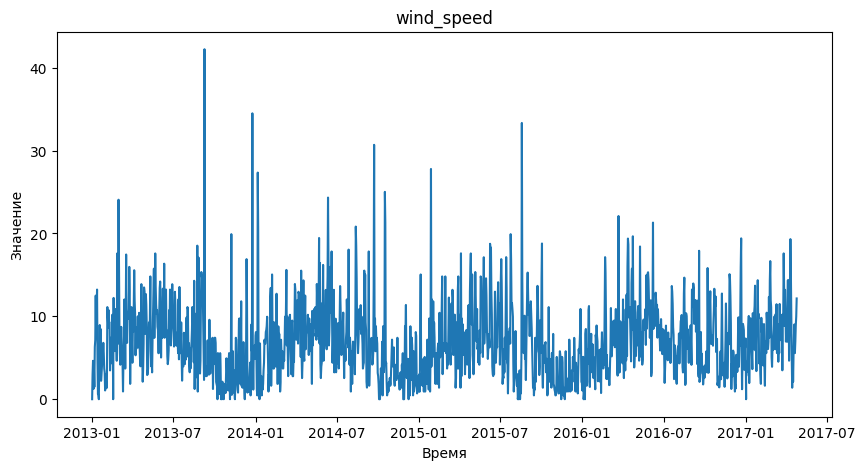

In [165]:
columns = data.columns

for column in columns:
    if column != 'Date':
        plt.figure(figsize=(10, 5))
        plt.plot(data[column])
        plt.title(column)
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.show()

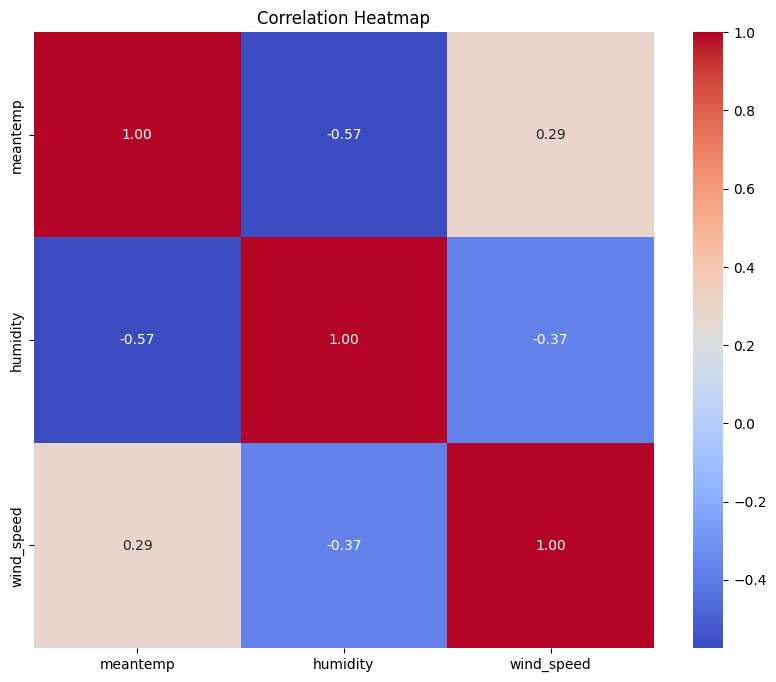

In [7]:

correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Проверка на пропуски

In [8]:
missing_values = data.isnull().sum()
missing_values

meantemp      0
humidity      0
wind_speed    0
dtype: int64

Составляющие ряда

In [177]:
def seasonal(column):
    rcParams['figure.figsize'] = 20, 10
    decompose = seasonal_decompose(data[column], period=180)
    decompose.plot()
    plt.show()


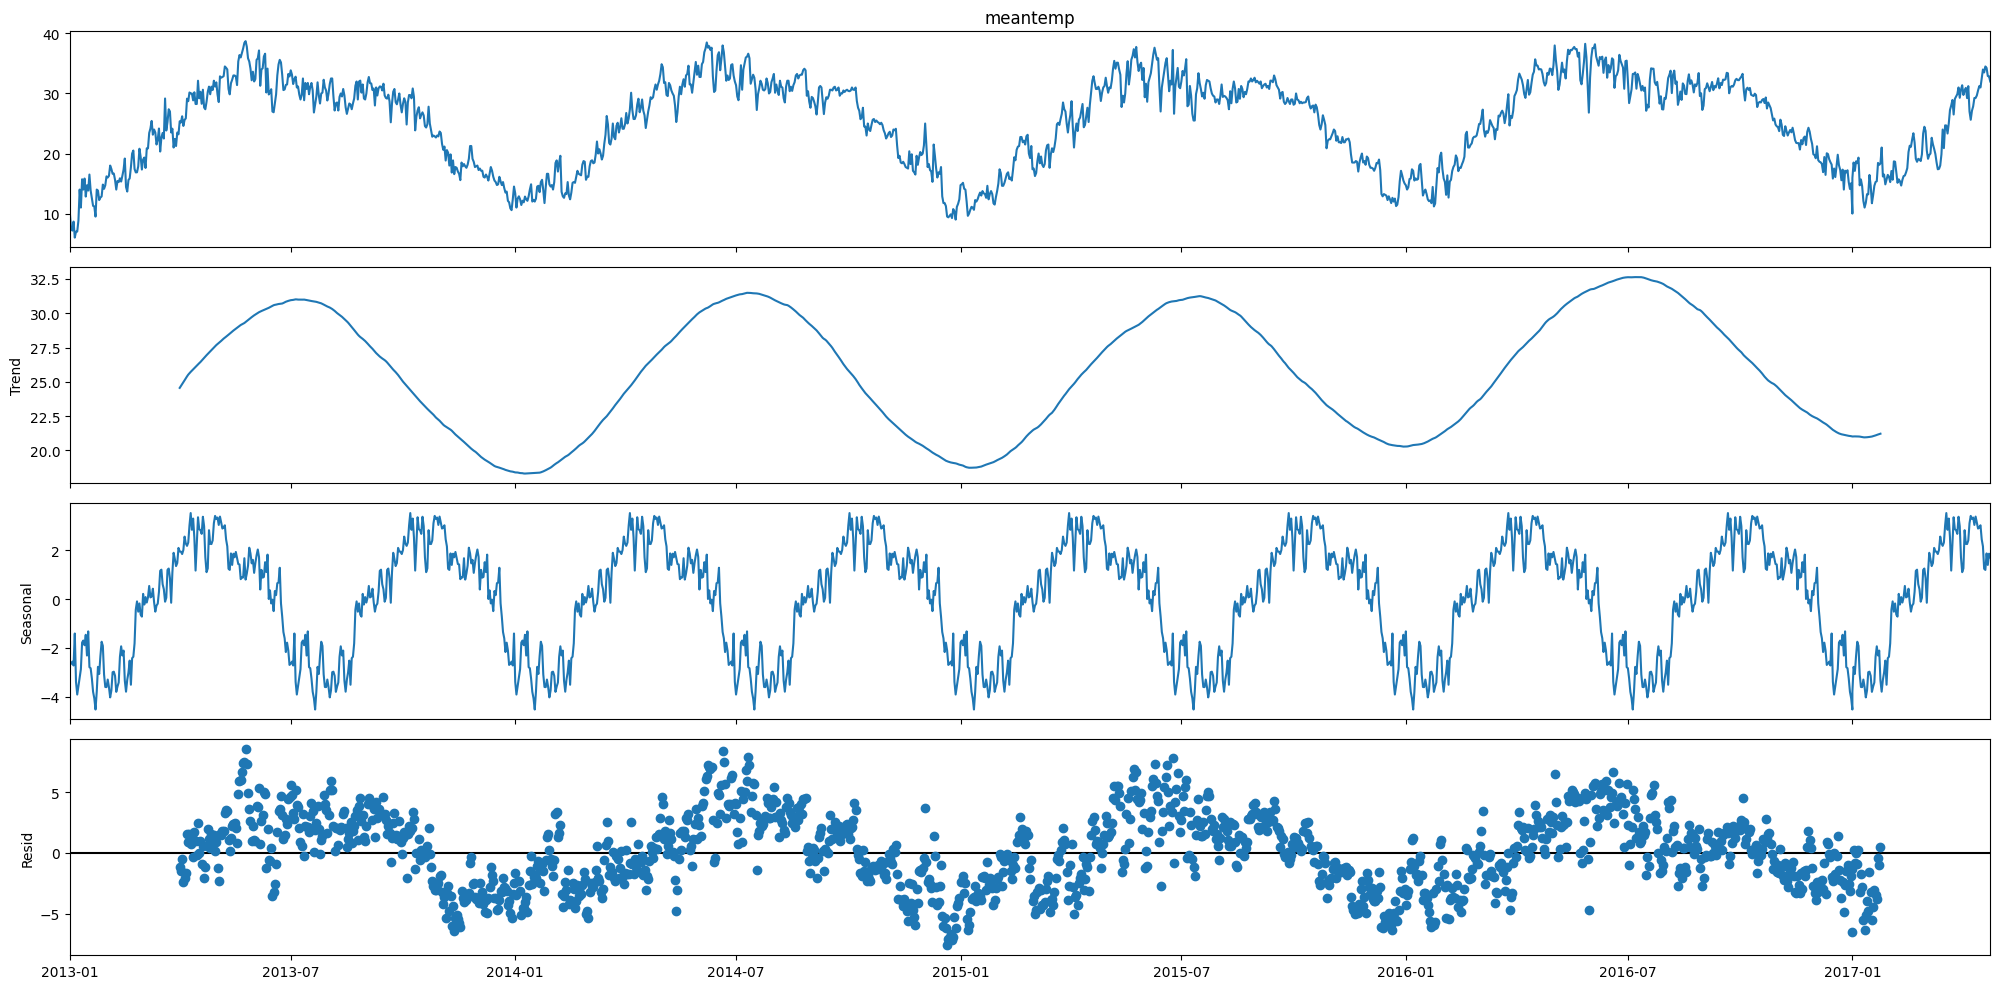

In [178]:
seasonal('meantemp')

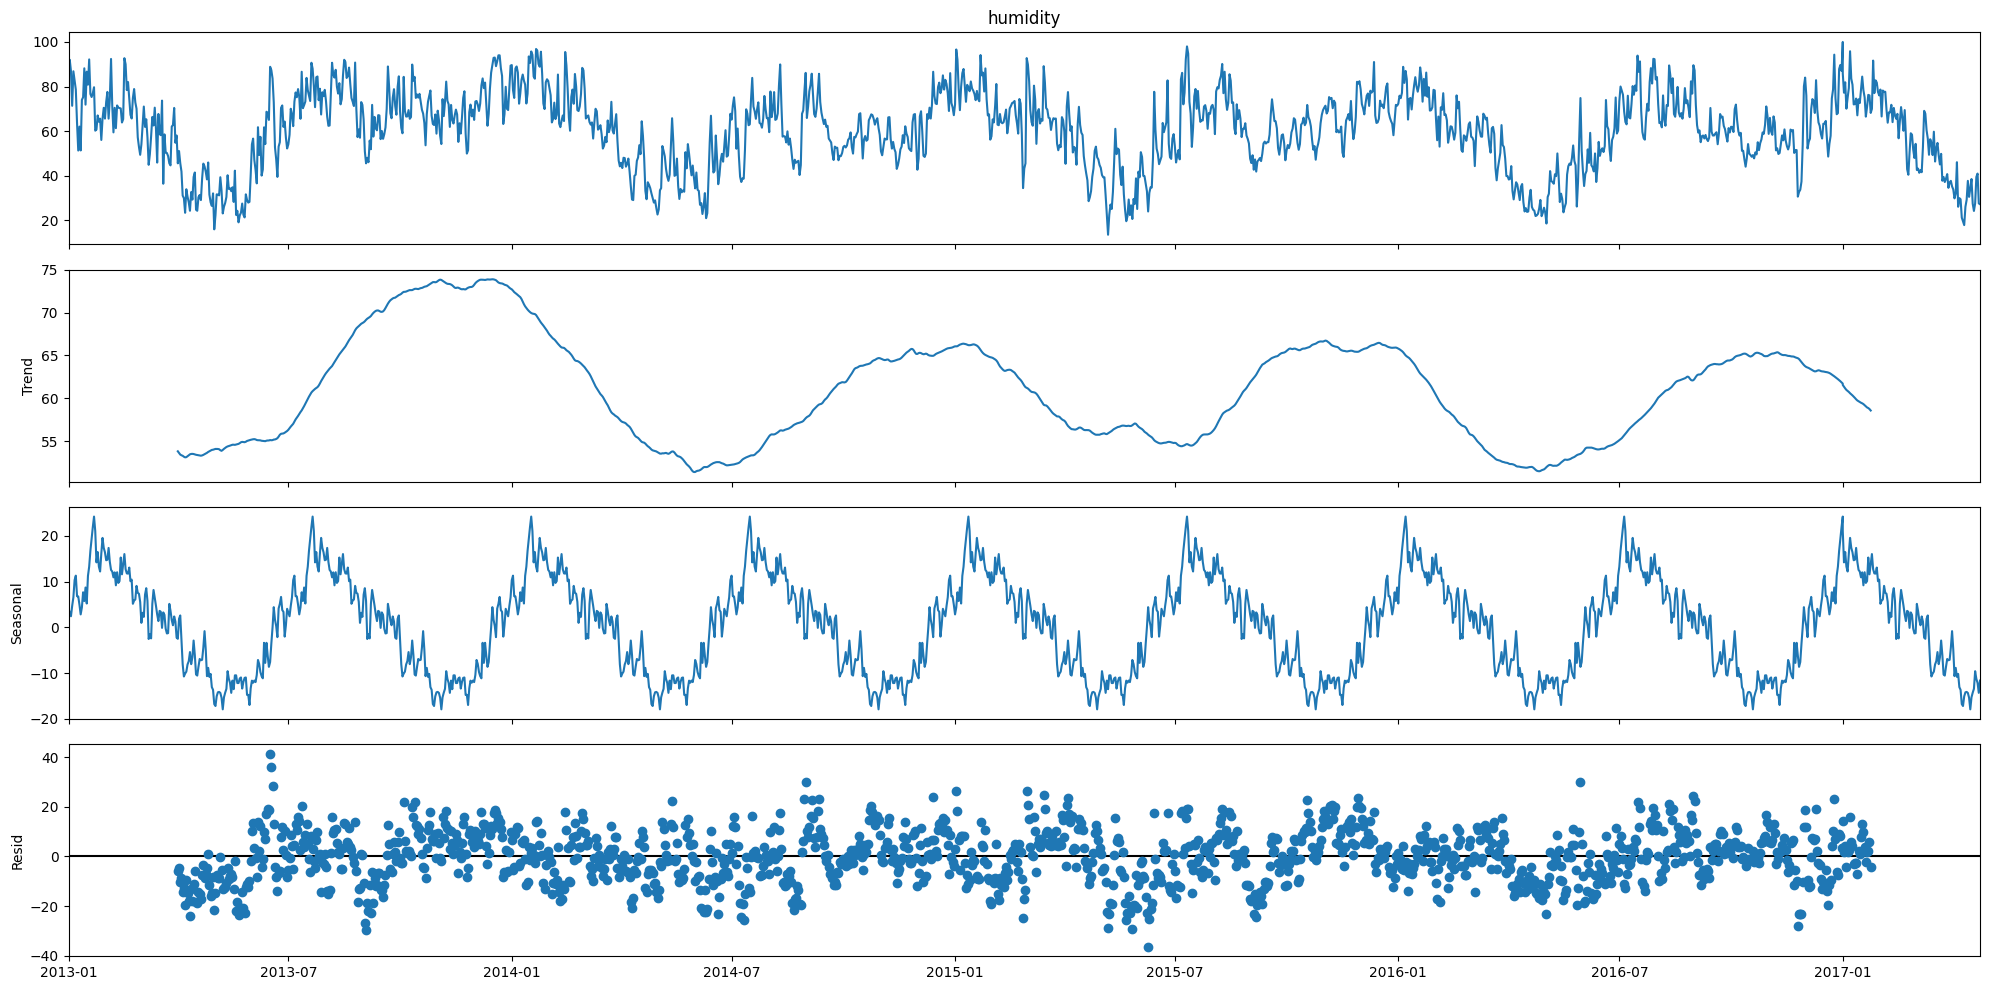

In [179]:
seasonal('humidity')

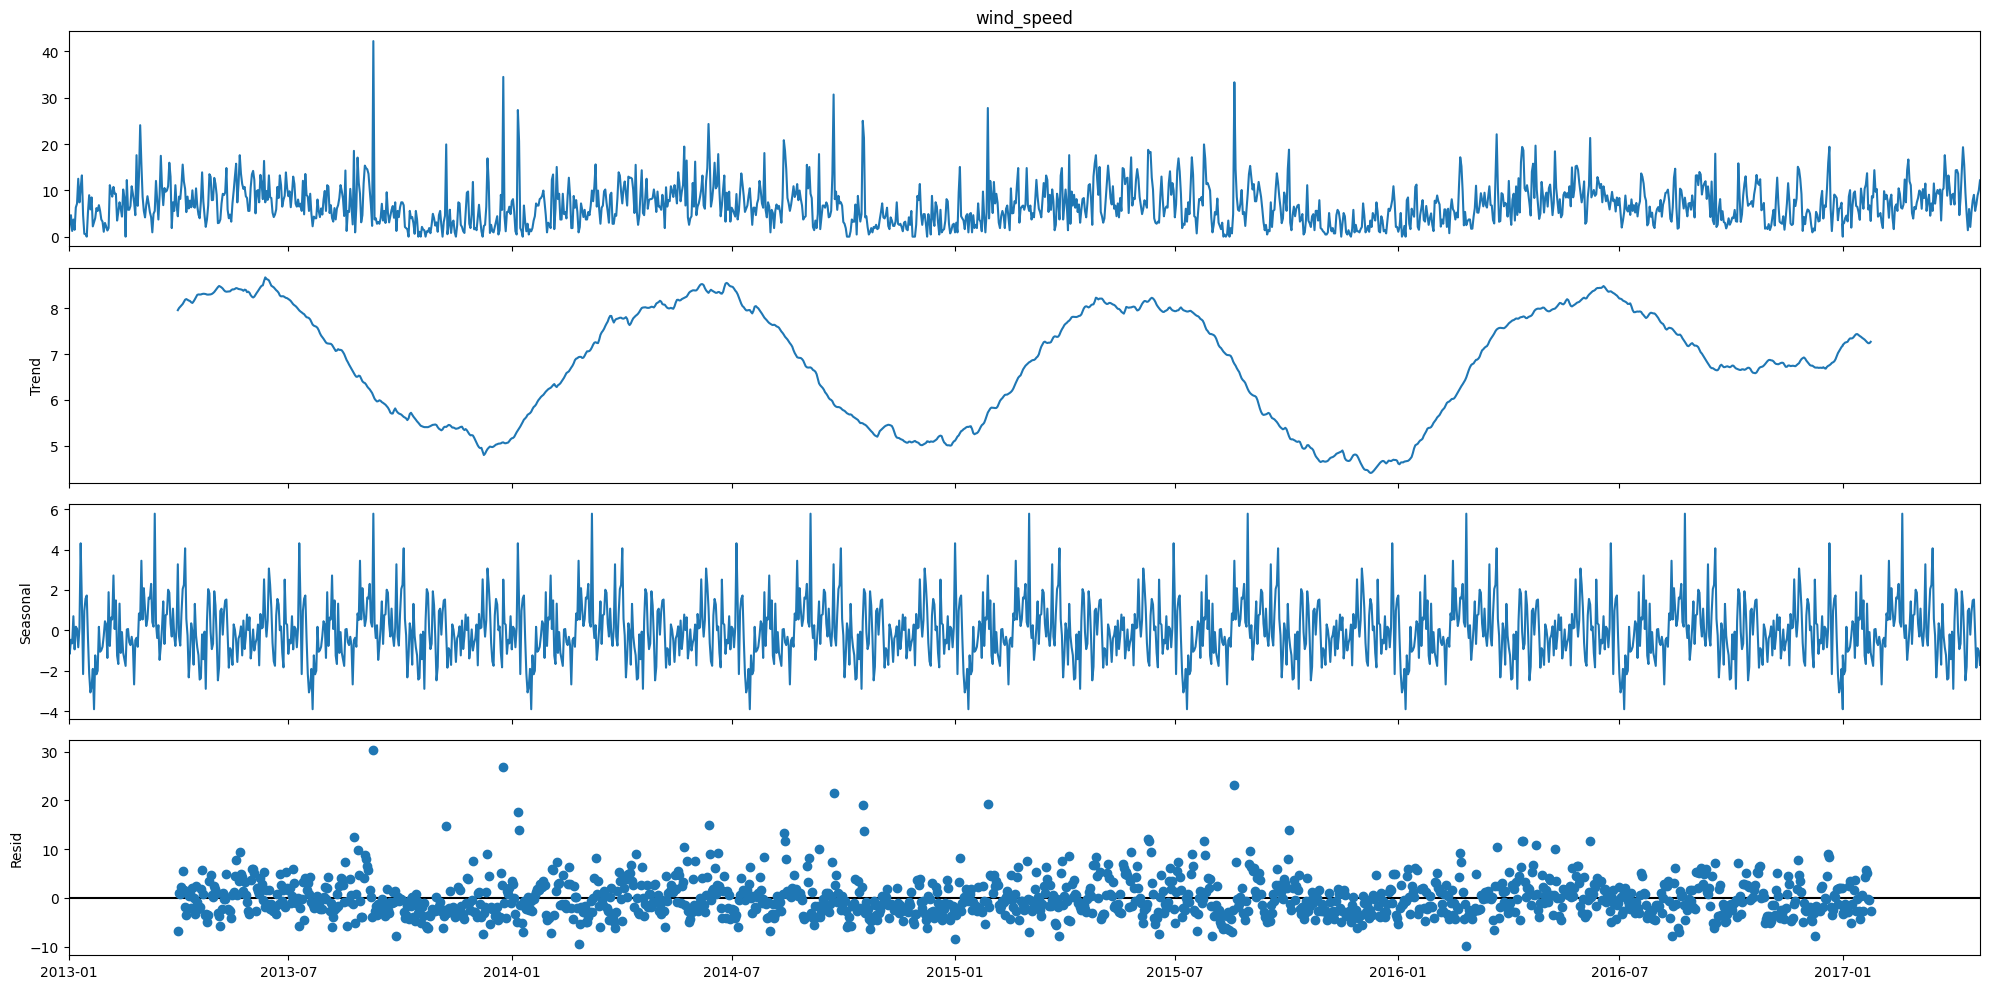

In [180]:
seasonal('wind_speed')

Проверка на стационарность

In [11]:
def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [12]:
df_test("meantemp", data["meantemp"])

Тест Дики-Фуллера ряда meantemp:
Test Statistic                   -2.379190
p-value                           0.147696
#Lags Users                      10.000000
Number of Observations Used    1565.000000
Critical Value (1%)              -3.434535
Critical Value (5%)              -2.863389
Critical Value (10%)             -2.567754
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


In [13]:
df_test("humidity", data["humidity"])

Тест Дики-Фуллера ряда humidity:
Test Statistic                   -3.628942
p-value                           0.005231
#Lags Users                      15.000000
Number of Observations Used    1560.000000
Critical Value (1%)              -3.434549
Critical Value (5%)              -2.863395
Critical Value (10%)             -2.567757
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [14]:
df_test("wind_speed", data["wind_speed"])

Тест Дики-Фуллера ряда wind_speed:
Test Statistic                   -4.013221
p-value                           0.001343
#Lags Users                      24.000000
Number of Observations Used    1551.000000
Critical Value (1%)              -3.434573
Critical Value (5%)              -2.863405
Critical Value (10%)             -2.567763
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Сезонное дифференцирование

In [15]:
# del data['date']
lags = 15
df_data = data.diff(periods=lags).dropna()
# data_test = data_test.diff(periods=lags).dropna()
df_test("meantemp", df_data["meantemp"])

Тест Дики-Фуллера ряда meantemp:
Test Statistic                   -4.925378
p-value                           0.000031
#Lags Users                      19.000000
Number of Observations Used    1541.000000
Critical Value (1%)              -3.434601
Critical Value (5%)              -2.863417
Critical Value (10%)             -2.567769
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


### Коинтеграция
Коинтеграция временных рядов представляет собой явление, при котором два или более временных ряда демонстрируют причинно-следственную зависимость на уровне их уровней, выраженную в совпадении или противоположной направленности общих тенденций и стохастических колебаний.

Обнаружение коинтеграции подразумевает, что эти временные ряды могут быть использованы для построения моделей, учитывающих их долгосрочные взаимосвязи с целью достижения более точных прогнозов. Для этого часто применяются модели, такие как VAR (векторная авторегрессия), VARMA (векторная авторегрессия с подвижным средним) и другие.

In [16]:
pairs = combinations(df_data.columns, 2)

for pair in pairs:
    pair_data = df_data[list(pair)]
    score, pvalue, _ = coint(pair_data[pair[0]], pair_data[pair[1]])

    if pvalue < 0.05:
        print(f"Есть коинтеграция между {pair[0]} и {pair[1]}")
    else:
        print(f"Отсутствует коинтеграция между {pair[0]} и {pair[1]}")

Есть коинтеграция между meantemp и humidity
Есть коинтеграция между meantemp и wind_speed
Есть коинтеграция между humidity и wind_speed


### Грейнджер


In [17]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in tqdm(df.columns):
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
warnings.filterwarnings("ignore")
j_test = grangers_causation_matrix(df_data, variables = data.columns)
warnings.filterwarnings("default")
j_test

100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


,meantemp_x,humidity_x,wind_speed_x
meantemp_y,1.0,0.0104,0.0000
humidity_y,0.0,1.0000,0.0615
wind_speed_y,0.0,0.0000,1.0000


In [18]:
train, test = df_data[:1200], df_data[1200:]

max_p = 100
model = VAR(df_data)

best_p = model.select_order(maxlags=max_p).selected_orders['aic']

print("Optimal p:", best_p)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal p: 93


In [19]:
model_fitted = model.fit(93)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 10, Jan, 2024
Time:                     14:36:39
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    10.8176
Nobs:                     1468.00    HQIC:                   8.91895
Log likelihood:          -11126.7    FPE:                    2450.17
AIC:                      7.78972    Det(Omega_mle):         1451.28
--------------------------------------------------------------------
Results for equation meantemp
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.006112         0.042811            0.143           0.886
L1.meantemp            0.800651         0.038305           20.902           0.000
L1.humidity            0.014016         0.008130     

In [20]:
def create_test_dataset(test, in_seq_order, for_len=1, step=1):
    X_test = []
    Y_test = []
    for i in range(0, len(test) - for_len - in_seq_order, step):
        X_test.append(test[i:(i+in_seq_order)].to_numpy())
        Y_test.append(test[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_test, Y_test

def create_train_dataset(train, in_seq_order, for_len=1, step=1):
    X_train = []
    Y_train = []
    for i in range(0, len(train) - for_len - in_seq_order, step):
        X_train.append(train[i:(i+in_seq_order)].to_numpy())
        Y_train.append(train[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_train, Y_train

In [21]:
X_test, Y_test = create_test_dataset(test, 93)
X_train, Y_train = create_train_dataset(train, 93)

In [22]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [23]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)

Y_train = np.array(Y_train)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def validate(name, true, pred):
    print(f"Метрики {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]

        plt.figure(figsize=(8, 6))
        # plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        validate(name, Y_true, Y_pred)

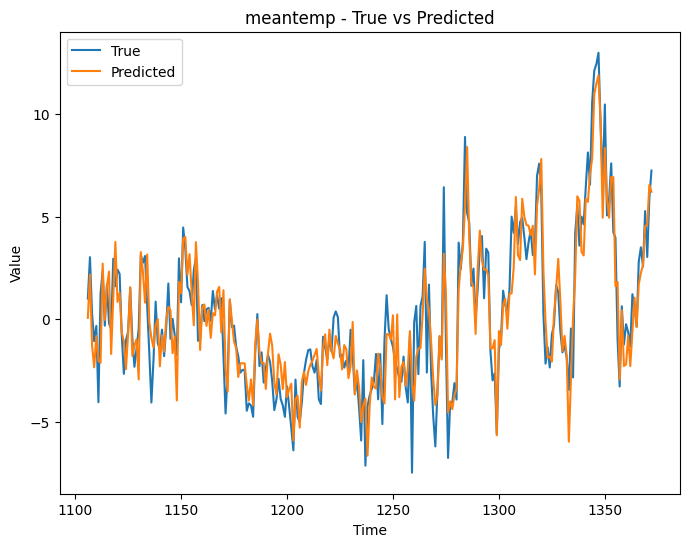

Метрики meantemp
MSE: 2.0713272317351934
RMSE: 1.4392106279954973
MAE: 1.1350909413931278
SMAPE: 0.16
R2: 0.8405721471966157 



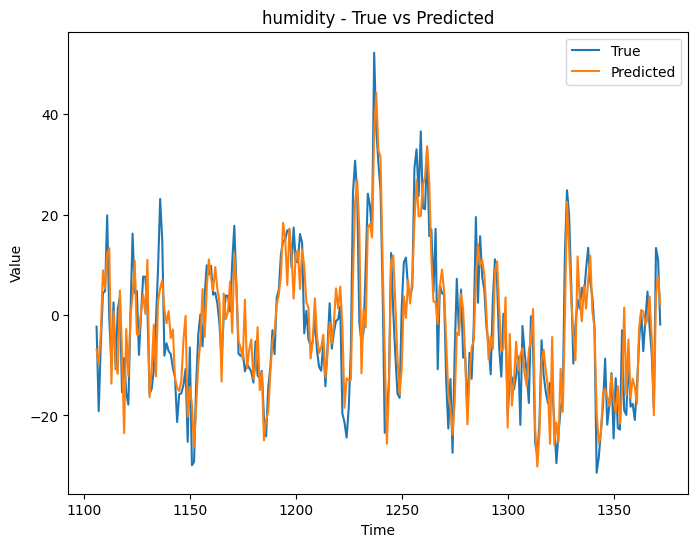

Метрики humidity
MSE: 48.31918264766755
RMSE: 6.9512000868675585
MAE: 5.558709754983595
SMAPE: 0.189
R2: 0.7638758119897967 



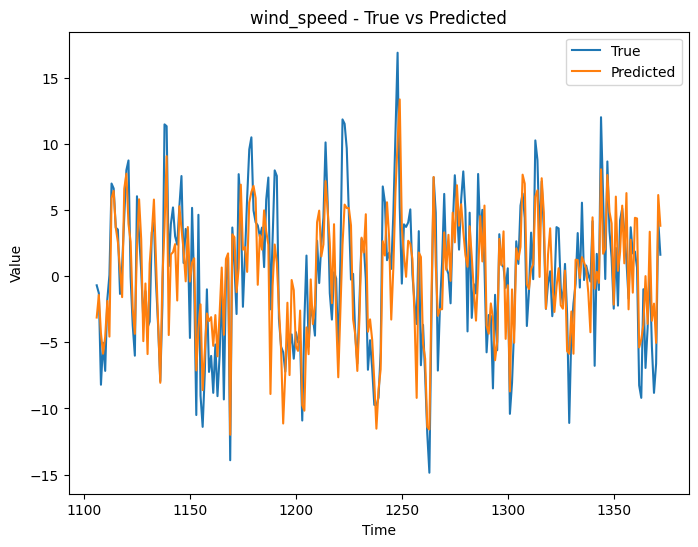

Метрики wind_speed
MSE: 10.529963968754672
RMSE: 3.2449905960964927
MAE: 2.6088994385473763
SMAPE: 0.216
R2: 0.6437479054031485 



In [25]:
plot_and_metrics(data.columns, Y_test, Y_pred, Y_train)

Метрики показывают достаточно средний результат предсказания
MSE RMSE MAE должны стремиться к 0
SMAPE R2 показывает что в среднем только около 80% данных объясняется моделью

### VARMA

In [26]:
train, test = data[:1200], data[1200:]
df_train = train.diff()

Подбор параметров для обучения

In [27]:
pq = []
for name, column in df_data.items():
    print(f'Поиск оптимальных значений p и q для: {name}')
    stepwise_model = auto_arima(data[name], start_p=1, start_q=1, max_p=7, max_q=7, seasonal=False,
        trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, maxiter=1000)
    params = stepwise_model.get_params().get('order')
    print(f'Оптимальные значения для {name}: {params} \n\n')
    pq.append(params)

Поиск оптимальных значений p и q для: meantemp
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6063.156, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14776.458, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12761.169, Time=0.89 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6004.752, Time=0.76 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6006.517, Time=2.63 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6066.979, Time=1.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6036.805, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6005.617, Time=2.71 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6001.754, Time=2.85 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6052.479, Time=1.37 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6061.620, Time=1.22 sec

In [28]:
pq.remove((2, 0, 1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        last_actual_value = actual_df[col].iloc[-1]
        df_res[str(col) + '_1st_inv_diff'] = last_actual_value + df_res[str(col)].cumsum()
    return df_res

In [30]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE meantemp','RMSE humidity','RMSE wind_speed'])
for i in pq:
    if i[0]== 0 and i[2]==0:
        pass
    else:
        model = VARMAX(df_train, order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = len(test))
        inv_res = inverse_diff(data, result)
        meantemprmse = np.sqrt(metrics.mean_squared_error(test['meantemp'], inv_res.meantemp_1st_inv_diff))
        humidityrmse = np.sqrt(metrics.mean_squared_error(test['humidity'], inv_res.humidity_1st_inv_diff))
        wind_speedrmse = np.sqrt(metrics.mean_squared_error(test['wind_speed'], inv_res.wind_speed_1st_inv_diff))
        new_row = {'p': i[0], 'q': i[2], 'RMSE meantemp':meantemprmse,'RMSE humidity':humidityrmse,'RMSE wind_speed':wind_speedrmse}
        df_results_moni = pd.concat([df_results_moni, pd.DataFrame([new_row])], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-package

In [31]:
df_results_moni.sort_values(by = ['RMSE meantemp','RMSE humidity','RMSE wind_speed'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,p,q,RMSE meantemp,RMSE humidity,RMSE wind_speed
0,4,1,10.395250,34.187669,5.110846
1,2,1,11.509095,34.978855,5.105656


4 и 1 лучшие параметры

In [32]:
model = VARMAX(df_train, order=(4, 1)).fit(disp=False, maxiter=100)
result = model.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

In [33]:
res = inverse_diff(data, result)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
def timeseries_metrics(y_true, y_pred):
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f"MAPE:, {mean_absolute_percentage_error(true, pred)}")
    print(f'R2: {metrics.r2_score(y_true, y_pred)}',end='\n\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


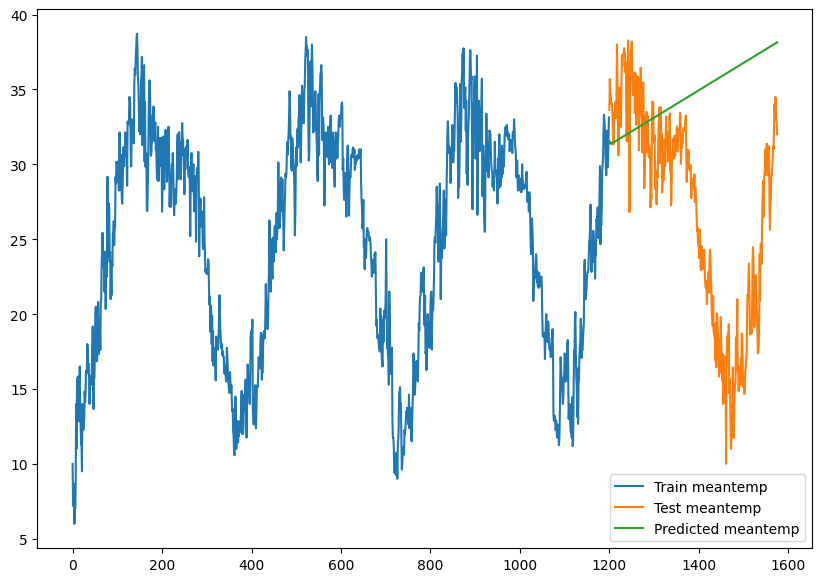

Evaluation metric for meantemp
MSE: 130.7535129980006
MAE: 8.876602283364415
RMSE: 11.434750237674656
SMAPE: nan
R2: -1.69391898716643



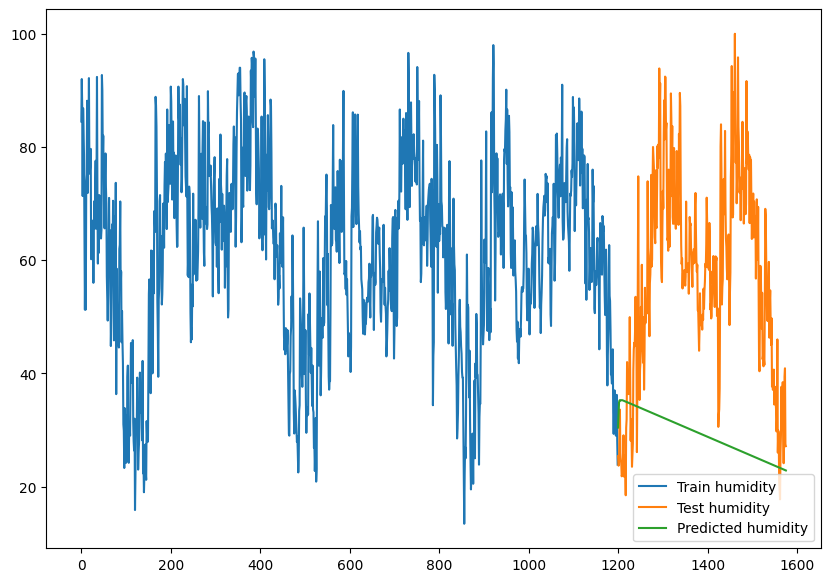

Evaluation metric for humidity
MSE: 1130.8634337480612
MAE: 29.594925472237275
RMSE: 33.62831297802584
SMAPE: nan
R2: -2.654204379606891



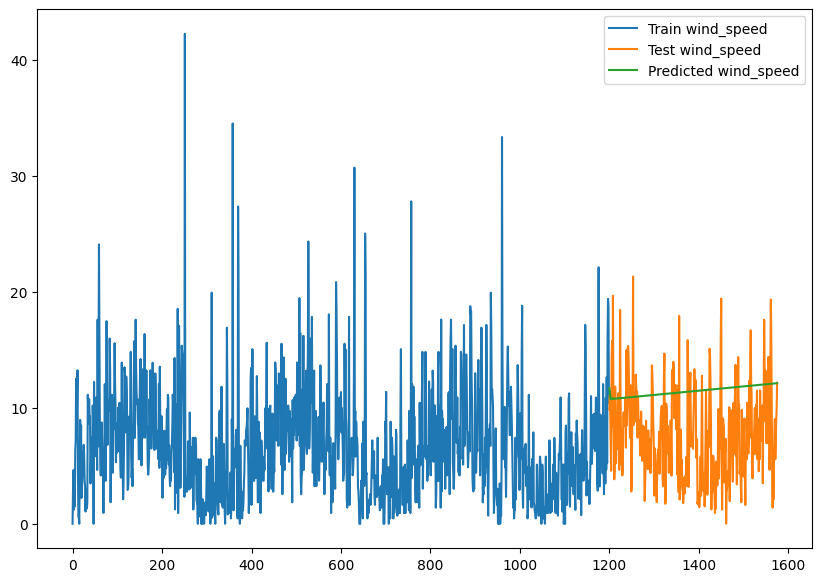

Evaluation metric for wind_speed
MSE: 28.87991956393022
MAE: 4.5813037904761655
RMSE: 5.374004053211182
SMAPE: nan
R2: -0.9982995241598902



In [36]:
for i in ['meantemp', 'humidity', 'wind_speed']:
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(train[str(i)], label='Train '+str(i))
    plt.plot(range(1200, len(data)), test[str(i)], label='Test '+str(i))
    plt.plot(range(1200, len(data)), res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

    print(f'Evaluation metric for {i}')
    timeseries_metrics(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Очень плохие графики и очень плохие метрики, я очень расстроен

### Нейросети

LSTM
Long Short-Term Memory (LSTM) - это тип рекуррентной нейронной сети (RNN), разработанный для эффективной обработки и моделирования последовательных данных. LSTM создана с целью преодоления проблемы затухания градиента, которая возникает при обучении традиционных RNN на длинных последовательностях данных.

In [39]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, cnn_out_channels, cnn_kernel_size):
        super(CNN_LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cnn1 = nn.Conv1d(input_size, cnn_out_channels, kernel_size=cnn_kernel_size, padding=3)
        self.cnn2 = nn.Conv1d(cnn_out_channels, cnn_out_channels, kernel_size=cnn_kernel_size, padding=3)
        self.cnn3 = nn.Conv1d(cnn_out_channels, cnn_out_channels, kernel_size=cnn_kernel_size, padding=3)
        self.lstm = nn.LSTM(cnn_out_channels, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x_cnn1 = x.permute(0, 2, 1)
        x_cnn1 = self.cnn1(x_cnn1)
        x_cnn1 = x_cnn1.permute(0, 2, 1)

        x_cnn2 = x_cnn1.permute(0, 2, 1)
        x_cnn2 = self.cnn2(x_cnn2)
        x_cnn2 = x_cnn2.permute(0, 2, 1)

        x_cnn3 = x_cnn2.permute(0, 2, 1)
        x_cnn3 = self.cnn3(x_cnn3)
        x_cnn3 = x_cnn3.permute(0, 2, 1)

        h0 = torch.zeros(self.num_layers,x_cnn1.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers,x_cnn1.size(0), self.hidden_size)
        out, _ = self.lstm(x_cnn3, (h0, c0))
        out = (out[:, -1, :])
        out = self.fc(out)
        return out

In [40]:
def split_data(data,time_step=12):
    dataX=[]
    datay=[]
    for i in range(len(data)-time_step):
        dataX.append(data[i:i+time_step])
        datay.append(data[i+time_step])
    dataX=np.array(dataX).reshape(len(dataX), time_step, -1)
    datay=np.array(datay)
    return dataX,datay

In [41]:
def train_test_split(dataX, datay, shuffle=True, percentage=0.8):
    if shuffle:
        random_num=[index for index in range(len(dataX))]
        np.random.shuffle(random_num)
        dataX=dataX[random_num]
        datay=datay[random_num]
    split_num=int(len(dataX)*percentage)
    train_X=dataX[:split_num]
    train_y=datay[:split_num]
    test_X=dataX[split_num:]
    test_y=datay[split_num:]
    return train_X,train_y,test_X,test_y

In [42]:
meantemp = data['meantemp'].values
scaler = MinMaxScaler()
meantemp = scaler.fit_transform(meantemp.reshape(-1,1))

In [43]:
dataX, datay = split_data(meantemp,time_step=12)
train_X,train_y,test_X,test_y=train_test_split(dataX,datay,shuffle=False,percentage=0.8)
X_train,y_train=train_X,train_y

In [42]:
test_X1=torch.Tensor(test_X)
test_y1=torch.Tensor(test_y)

input_size = 3
hidden_size = 64
num_layers = 3
output_size = 3
cnn_out_channels = 32
cnn_kernel_size = 7

model = CNN_LSTM(input_size, hidden_size, num_layers, output_size, cnn_out_channels, cnn_kernel_size)

num_epochs=300
batch_size=64
optimizer=optim.Adam(model.parameters(),lr=0.0001,betas=(0.5,0.999))
criterion=nn.MSELoss()

train_losses=[]
test_losses=[]

print(f"start")

for epoch in range(num_epochs):
    random_num=[i for i in range(len(train_X))]
    np.random.shuffle(random_num)

    train_X=train_X[random_num]
    train_y=train_y[random_num]

    train_X1=torch.Tensor(train_X[:batch_size])
    train_y1=torch.Tensor(train_y[:batch_size])

    model.train()
    optimizer.zero_grad()
    output=model(train_X1)
    train_loss=criterion(output,train_y1)
    train_loss.backward()
    optimizer.step()

    if epoch % 50==0:
        model.eval()
        with torch.no_grad():
            output = model(test_X1)
            test_loss=criterion(output,test_y1)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"epoch:{epoch},train_loss:{train_loss},test_loss:{test_loss}")

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

start
epoch:0,train_loss:0.37887176871299744,test_loss:0.3254355192184448
epoch:50,train_loss:0.024630708619952202,test_loss:0.02005927264690399
epoch:100,train_loss:0.006815223954617977,test_loss:0.005577520467340946
epoch:150,train_loss:0.006091523915529251,test_loss:0.004885882139205933
epoch:200,train_loss:0.004852983634918928,test_loss:0.0048286691308021545
epoch:250,train_loss:0.004634431563317776,test_loss:0.004810840357095003


In [43]:
train_X1 = torch.Tensor(X_train)
train_pred = model(train_X1).detach().numpy()
test_pred = model(test_X1).detach().numpy()
pred_y = np.array(test_pred)
pred_y = scaler.inverse_transform(pred_y).T[0]
true_y = np.array(test_y)
true_y = scaler.inverse_transform(true_y).T[0]

SMAPE: 0.019
RMSE: 2.2494158734593035
MAE: 1.753653316169005
MSE: 5.0598717717706805
R2: 0.8827238720463292


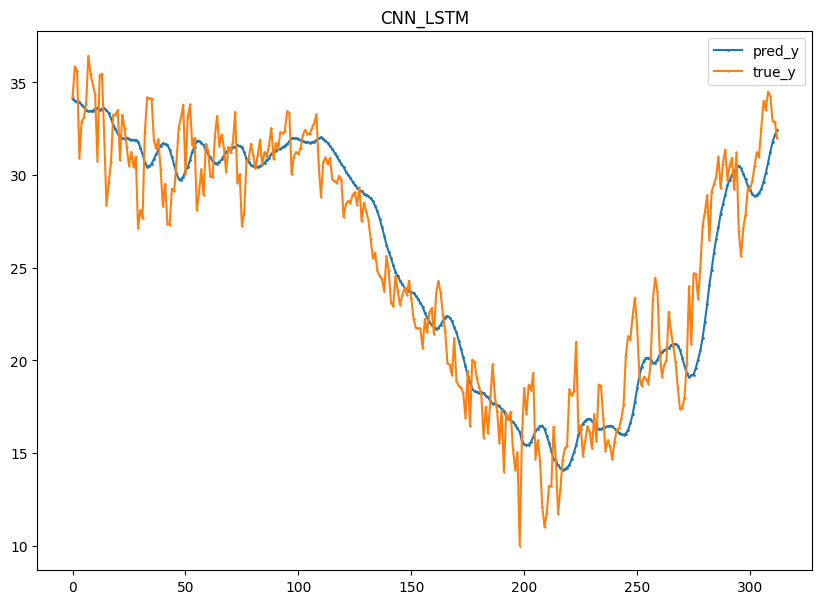

In [44]:
true = pd.DataFrame(true_y.flatten())[0]
pred = pd.DataFrame(pred_y.flatten())[0]

print(f"MAPE:, {mean_absolute_percentage_error(true, pred)}")
print("RMSE:", sqrt(mean_squared_error(true, pred)))
print("MAE:", mean_absolute_error(true, pred))
print("MSE:", mean_squared_error(true, pred))
print("R2:", r2_score(true, pred))


plt.title("CNN_LSTM")
x=[i for i in range(len(true_y))]
plt.plot(x,pred_y,marker="o",markersize=1,label="pred_y")
plt.plot(x,true_y,marker="x",markersize=1,label="true_y")
plt.legend()
plt.show()

Полученные метрики оценки модели подтверждают высокое качество прогнозов. SMAPE составляет 7.67%, RMSE - 2.25, MAE - 1.78, MSE - 5.04, а коэффициент детерминации R2 равен 0.88. Эти значения свидетельствуют о том, что наша модель успешно справляется с предсказанием целевой переменной, а коэффициент R2 указывает на хорошее объяснение вариации в данных. Таким образом, можно утверждать, что разработанная модель демонстрирует высокую точность и надежность в своих прогнозах.

### GRU
Gated Recurrent Unit (GRU) - это тип рекуррентной нейронной сети (RNN), предназначенной для работы с последовательными данных, такими как временные ряды, тексты или звуковые сигналы. GRU является вариацией более традиционных RNN, предлагая решение для проблемы затухания градиента, с которой сталкиваются некоторые другие архитектуры.

In [78]:
class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=3, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 3)
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x


In [47]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset.iloc[i:(i + lookback)].values
        target = dataset.iloc[i + lookback].values
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [75]:
def train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_l1, n_epochs, patience):
    y_pred_train = None
    y_pred_test = None
    min_test_rmse = np.inf
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_l1(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_l1(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_l1(y_pred, y_test))

            if test_rmse < min_test_rmse:
                min_test_rmse = test_rmse
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            print(f'Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}')

            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch} epochs')
                break

    return y_pred_train, y_pred_test, model

In [79]:
data_train = pd.read_csv('DailyDelhiClimateTrain.csv')
data_test = pd.read_csv('DailyDelhiClimateTest.csv')

data = pd.concat([data_train, data_test], axis=0)

data_GRU = pd.DataFrame(data['date'])
data_GRU['meantemp'] = data['meantemp']
data_GRU['humidity'] = data['humidity']
data_GRU['wind_speed'] = data['wind_speed']
data_GRU.set_index('date', inplace=True)


train, test = data_GRU[:1200], data_GRU[1200:]
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

model = GRUModel()
optimizer = optim.Adamax(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32)

EPOCHS = 100

train_model(model, X_train, X_test, y_train, y_test, optimizer, loader, loss_fn, EPOCHS, patience=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 3])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15, 3])) that is different to the input size (torch.Size([15, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1199, 3])) that is different to the input size (torch.Size([1199, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  re

Epoch 0: train RMSE 37.5927, test RMSE 36.2906
Epoch 1: train RMSE 35.5392, test RMSE 34.1744
Epoch 2: train RMSE 33.3357, test RMSE 31.9288
Epoch 3: train RMSE 31.2401, test RMSE 29.7824
Epoch 4: train RMSE 29.1759, test RMSE 27.6794
Epoch 5: train RMSE 27.1582, test RMSE 25.6438
Epoch 6: train RMSE 25.3060, test RMSE 23.7806
Epoch 7: train RMSE 23.6599, test RMSE 22.1382
Epoch 8: train RMSE 22.0445, test RMSE 20.5333
Epoch 9: train RMSE 20.6091, test RMSE 19.1252
Epoch 10: train RMSE 19.2946, test RMSE 17.8551
Epoch 11: train RMSE 18.1020, test RMSE 16.7179
Epoch 12: train RMSE 17.0312, test RMSE 15.7185
Epoch 13: train RMSE 16.0520, test RMSE 14.8215
Epoch 14: train RMSE 15.1826, test RMSE 14.0544
Epoch 15: train RMSE 14.4191, test RMSE 13.3984
Epoch 16: train RMSE 13.7640, test RMSE 12.8578
Epoch 17: train RMSE 13.1961, test RMSE 12.4107
Epoch 18: train RMSE 12.7210, test RMSE 12.0611
Epoch 19: train RMSE 12.3132, test RMSE 11.7811
Epoch 20: train RMSE 11.9854, test RMSE 11.5746
Ep

(tensor([[[24.6486, 60.8985,  6.7197]],
 
         [[24.6523, 60.9078,  6.7207]],
 
         [[24.6510, 60.9044,  6.7205]],
 
         ...,
 
         [[24.6502, 60.9044,  6.7196]],
 
         [[24.6532, 60.9118,  6.7203]],
 
         [[24.6457, 60.8937,  6.7185]]]),
 tensor([[[24.6248, 60.8421,  6.7129]],
 
         [[24.6268, 60.8473,  6.7133]],
 
         [[24.6185, 60.8264,  6.7110]],
 
         ...,
 
         [[24.6488, 60.9003,  6.7190]],
 
         [[24.6515, 60.9073,  6.7198]],
 
         [[24.6313, 60.8580,  6.7146]]]),
 GRUModel(
   (gru): GRU(3, 50, batch_first=True)
   (linear): Linear(in_features=50, out_features=3, bias=True)
 ))

In [59]:
y_train.shape

torch.Size([1199, 3])

In [60]:
X_train.shape

torch.Size([1199, 1, 3])

In [9]:
X_test.shape

torch.Size([375, 1, 3])

In [10]:
y_test.shape

torch.Size([375, 3])

In [82]:
def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]

    print(f"MAPE:, {mean_absolute_percentage_error(true, pred)}")
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MSE:", mean_squared_error(true, pred))
    print("R2:", r2_score(true, pred))

def plot_train_n_pred(X_train, X_test, total, model, index):
    with torch.no_grad():
        lookback = X_train.shape[1]
        train_size = len(X_train)

        y_test_pred = model(X_test).numpy()


    plt.rcParams["figure.figsize"] = [30, 12]
    plt.plot(total, c='b', label='Total')
    plt.plot(y_test_pred[:, index], c='g', label='Test Predictions')
    plt.legend(fontsize="20")
    plt.show()

def validate_on_auto_measurement(model):
    for i in range(1):
      y_pred = model(X_test)
      y_pred_test = y_pred[:, i]
      y_test_new = y_test[:, i]
      X_test_new = X_test[:, i]
      y_train_new = y_train[:, i]
      X_train_new = X_train[:, i]

      print("GRU metrics: ")
      try:
          validate(y_pred_test, y_test_new)
      except:
          validate(y_pred_test.detach(), y_test.detach())
      # plot_train_n_pred(X_train_new, X_test_new, y_train_new, model, i)


validate_on_auto_measurement(model)

GRU metrics: 
MAPE:, 0.319951593875885
RMSE: 11.362395628732003
MAE: 7.9871473
MSE: 129.10403
R2: 0.745844166401304


MAPE близок к 0 - хороший результат
RMSE MAE MSE показывают средний результат
R2 > 0.75 - хорошо

### TCN

TCN (Temporal Convolutional Network) - это тип нейронной сети, предназначенный для работы с последовательными данных, такими как временные ряды. Эта архитектура основана на использовании сверточных слоев для извлечения признаков из последовательных данных.

In [181]:
data_train = pd.read_csv('DailyDelhiClimateTrain.csv')
data_test = pd.read_csv('DailyDelhiClimateTest.csv')

data = pd.concat([data_train, data_test], axis=0)

df_tcn = pd.DataFrame(data['date'])
df_tcn['meantemp'] = data['meantemp']
df_tcn['humidity'] = data['humidity']
df_tcn['wind_speed'] = data['wind_speed']
df_tcn.set_index('date', inplace=True)

lookback_window = 20

df_tcn = df_tcn.values

x, y = [], []
for i in range(lookback_window, len(df_tcn)):
    x.append(df_tcn[i - lookback_window:i])
    y.append(df_tcn[i])
x = np.array(x)
y = np.array(y)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [182]:
x_train = x[0:1200]
y_train = y[0:1200]
x_test = x[1200:]
y_test = y[1200:]

In [183]:
i = Input(shape=(lookback_window, 3))
m = TCN()(i)
m = Dense(3, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20, 3)]           0         
                                                                 
 tcn_3 (TCN)                 (None, 64)                136768    
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 136963 (535.01 KB)
Trainable params: 136963 (535.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [184]:
model.fit(x_train, y_train, epochs=150, verbose=0)

12/12 [==============================] - 1s 12ms/step


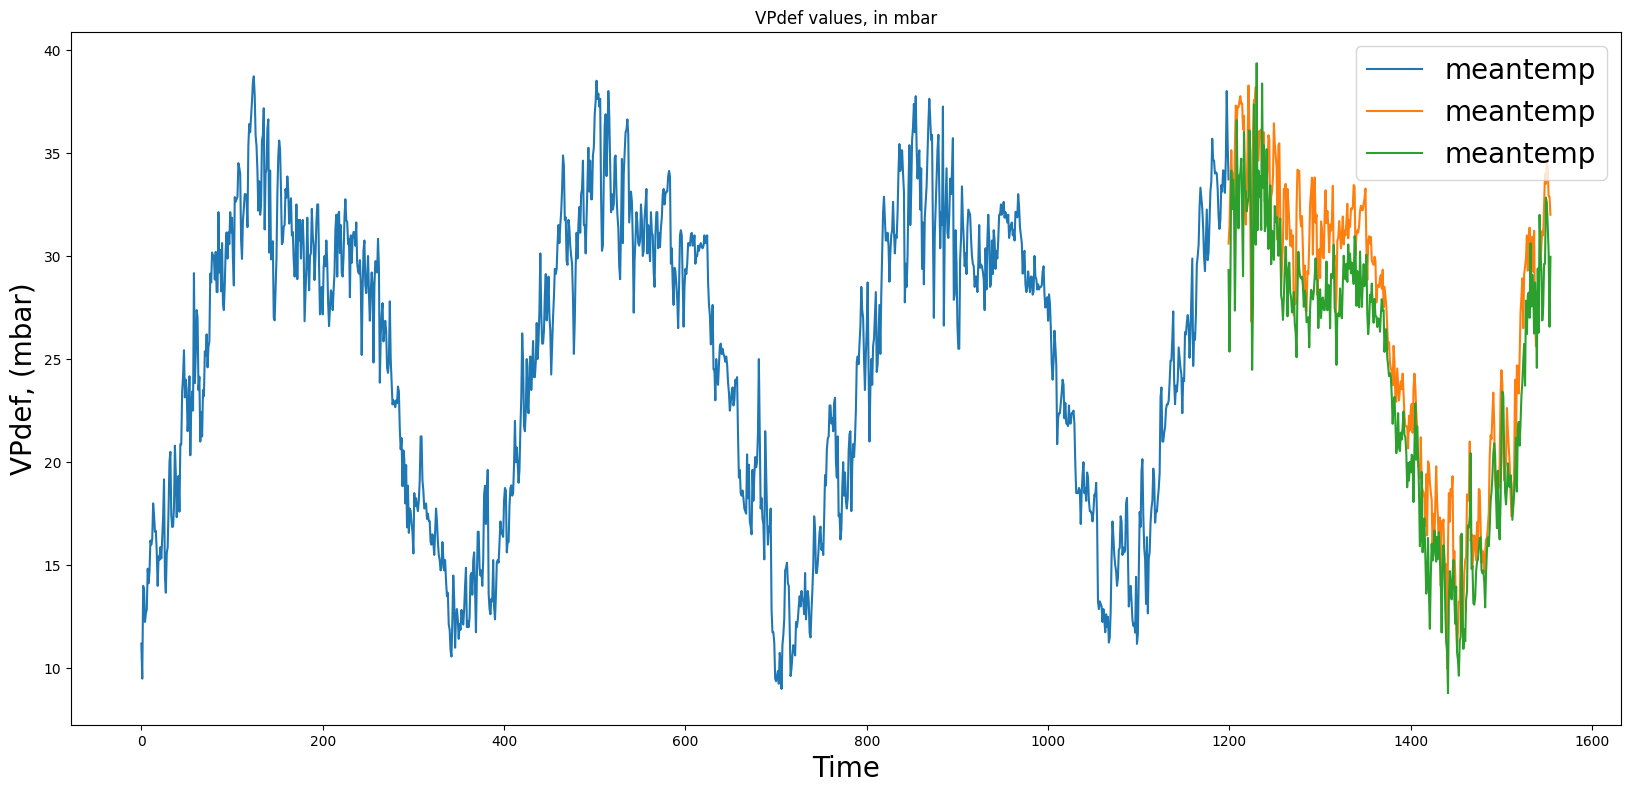

TCN Metrics:
RMSE: 3.158010082879372
MSE: 9.973027683567777
SMAPE: 0.027
MAE: 2.6411121939637003
R^2: 0.7934543602453554


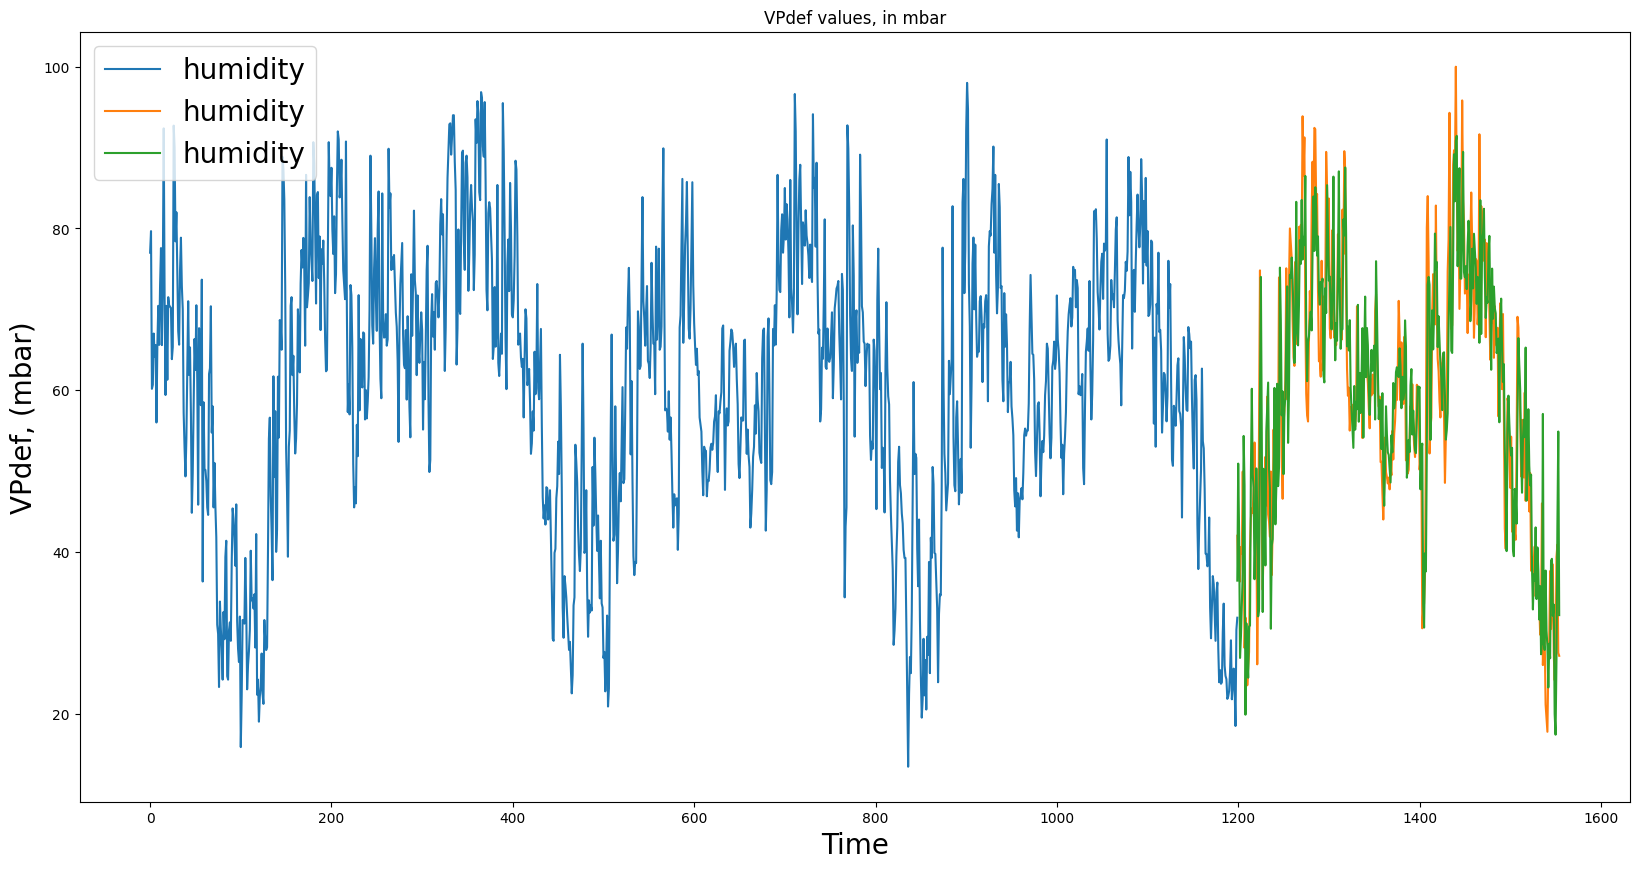

TCN Metrics:
RMSE: 8.592785735168656
MSE: 73.83596669051794
SMAPE: 0.03
MAE: 6.5790133642126865
R^2: 0.7212872822302406


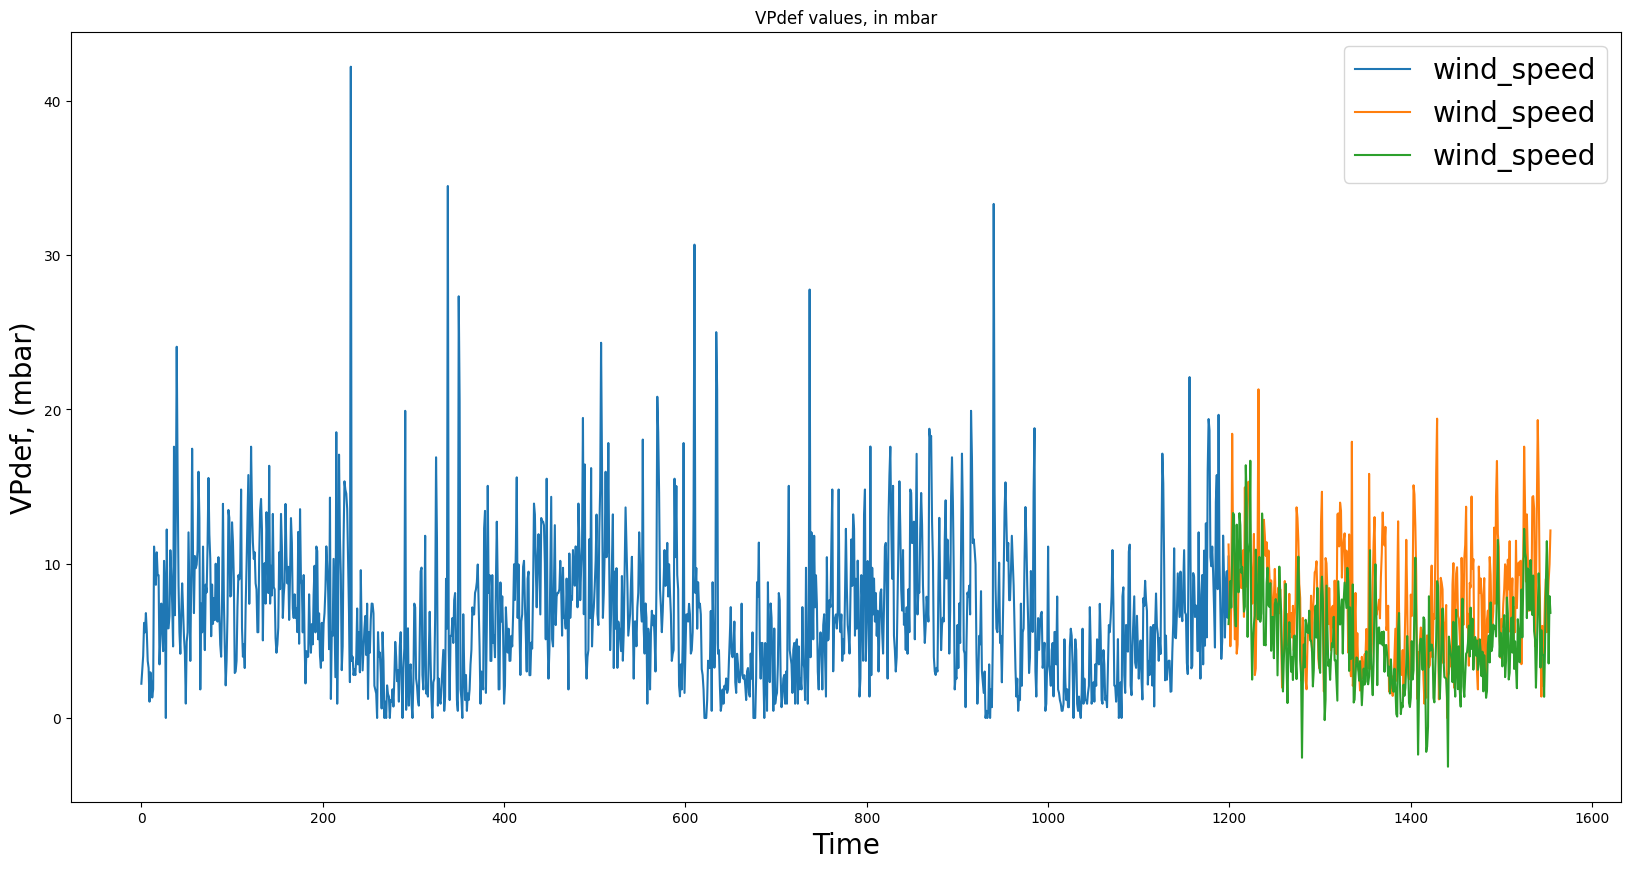

TCN Metrics:
RMSE: 4.477470634854949
MSE: 20.047743285988382
SMAPE: 0.148
MAE: 3.5050922899709622
R^2: -0.4038352972450121


In [186]:
y_pred = model.predict(x_test)
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = ['meantemp', 'humidity', 'wind_speed']
for j in range(3):
  y_test_new = y_test[:, j]
  y_pred_new = y_pred[:, j]

  plt.plot([i for i in range(0, size)], y_train[:, j], label=columns[j])
  plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_new, label=columns[j])
  plt.plot([i for i in range(size - 1, size - 1 + dur)], y_pred_new, label=columns[j])
  plt.legend(fontsize="20")
  plt.title('VPdef values, in mbar')
  plt.ylabel('VPdef, (mbar)', fontsize="20")
  plt.xlabel('Time', fontsize="20")
  plt.show()

  def smape_score(y_true, y_pred):
      return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

  print("TCN Metrics:")
  print("RMSE:", np.sqrt(mean_squared_error(y_test_new, y_pred_new)))
  print("MSE:", mean_squared_error(y_test_new, y_pred_new))
  print("SMAPE:", smape_score(y_test_new, y_pred_new))
  print("MAE:", mean_absolute_error(y_test_new, y_pred_new))
  print("R^2:", r2_score(y_test_new, y_pred_new))

Все аналогично GRU

### Выводы

Из классических моделей VAR показал себя лучше чем VARMAX, но все равно результат очень средний. Думаю дело в не очень хороших результатах теста Грейнджера

Нейронки показали себя лучше, GRU и TCN предсказывают одинаково хорошо, LSTM чуть похуже + пришлось выставлять много слоев

Для прогнозирования данного датасета я бы использовал GRU, потому что TCN долго учится, а результат один
